In [ ]:
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', '37c698f953ab48379ad95245eb0c26c6')
print(key)

37c698f953ab48379ad95245eb0c26c6


In [ ]:
phone_list = [f"iphone {i}" for i in range(6, 13)]
phone_list

['iphone 6',
 'iphone 7',
 'iphone 8',
 'iphone 9',
 'iphone 10',
 'iphone 11',
 'iphone 12']

In [ ]:
phone_path = Path('phone')

if not phone_path.exists():
    phone_path.mkdir()

for phone in phone_list:
    # create new folder for each type
    phone_folder = (phone_path/phone)
    phone_folder.mkdir(exist_ok=True)
    
    # get all the images
    phone_urls = search_images_bing(key, phone).attrgot('contentUrl')
    
    # download the phone images into the specific location
    download_images(phone_folder, urls=phone_urls)

In [ ]:
phone_files = get_image_files(phone_path)
phone_files

(#985) [Path('phone/iphone 12/00000022.png'),Path('phone/iphone 12/00000047.jpg'),Path('phone/iphone 12/00000055.jpg'),Path('phone/iphone 12/00000081.png'),Path('phone/iphone 12/00000107.jpg'),Path('phone/iphone 12/00000030.jpg'),Path('phone/iphone 12/00000097.jpg'),Path('phone/iphone 12/00000110.jpg'),Path('phone/iphone 12/00000112.jpg'),Path('phone/iphone 12/00000090.jpg')...]

In [ ]:
# check for any error files
error_files = verify_images(phone_files)
error_files

(#17) [Path('phone/iphone 12/00000023.jpg'),Path('phone/iphone 12/00000133.jpg'),Path('phone/iphone 12/00000117.png'),Path('phone/iphone 11/00000068.jpg'),Path('phone/iphone 11/00000042.jpg'),Path('phone/iphone 11/00000096.jpg'),Path('phone/iphone 11/00000062.png'),Path('phone/iphone 11/00000145.jpg'),Path('phone/iphone 10/00000022.png'),Path('phone/iphone 10/00000011.png')...]

In [ ]:
error_files.map(Path.unlink)

(#17) [None,None,None,None,None,None,None,None,None,None...]

### Now, there are folders with iphone 6 to iphone 12
- create data blocks for the model
- the item transforms should have batch augmentation applied (faster since it happens on the gpu)

In [ ]:
phone_data = DataBlock(
    # input types (X, y)
    blocks = (ImageBlock, CategoryBlock),
    # how to get the images
    get_items = get_image_files,
    # how to split X
    splitter = RandomSplitter(valid_pct=0.2, seed=8),
    # how to get y label
    get_y = parent_label,
    # resize so that each image can fit into a tensor
    item_tfms = Resize(224)
)

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


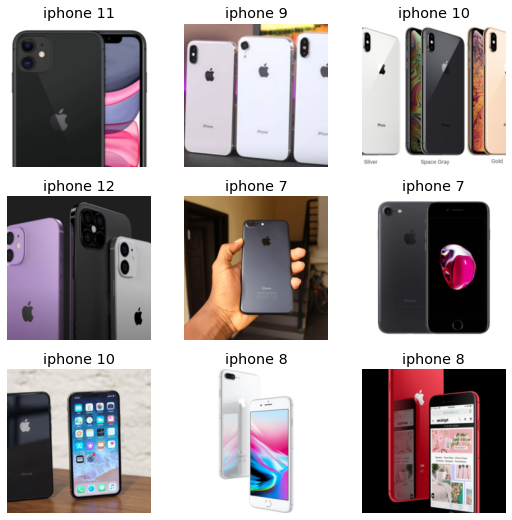

In [ ]:
dls = phone_data.dataloaders(phone_path)
dls.valid.show_batch()

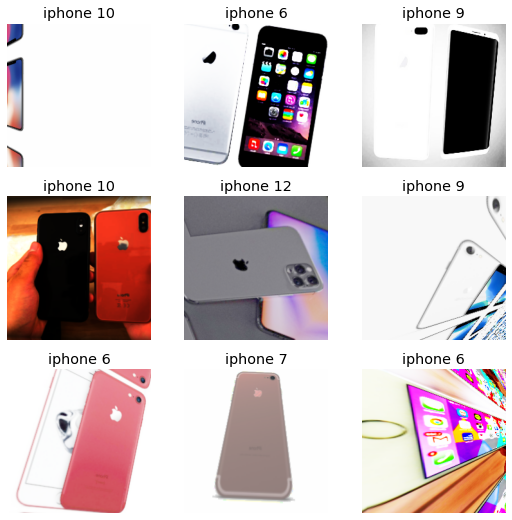

In [ ]:
phone_data_aug = phone_data.new(
    item_tfms = Resize(224),
    batch_tfms = aug_transforms(4)
)
dls = phone_data_aug.dataloaders(phone_path)
dls.train.show_batch()

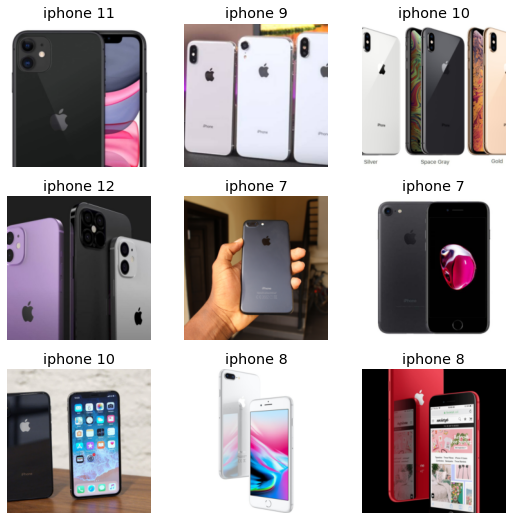

In [ ]:
# note: augmentation not applied to validation set
dls.valid.show_batch()

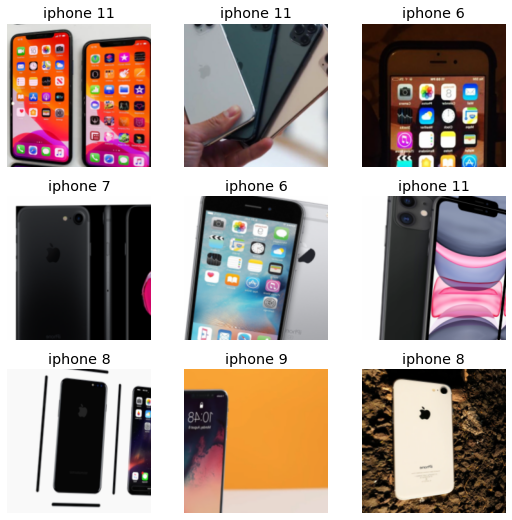

In [ ]:
phone_data_final = phone_data.new(
    # for the final version crop and augment the training data for best results
    item_tfms = RandomResizedCrop(224, 0.4),
    batch_tfms = aug_transforms()
)

dls_final = phone_data_final.dataloaders(phone_path)
dls_final.train.show_batch()

In [ ]:
# use transfer learning to make a new head for a resnet model
learn = cnn_learner(dls_final, resnet34, metrics=error_rate)
# train the head for 8 epochs
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.862184,1.786333,0.611399,00:16


epoch,train_loss,valid_loss,error_rate,time
0,1.986776,1.972662,0.668394,00:21
1,1.758482,1.946162,0.642487,00:21
2,1.548479,1.942314,0.590674,00:21
3,1.402315,1.828827,0.544041,00:20
4,1.238197,1.863501,0.549223,00:20
5,1.097884,1.779593,0.538860,00:20
6,0.958866,1.711218,0.549223,00:22
7,0.871729,1.708280,0.549223,00:22


### Interpret the fails of the model
- See if any of the input data entered into the model was incorrect
- See the confusion matrix of the results

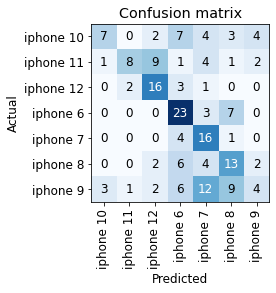

In [ ]:
interpret_mistakes = ClassificationInterpretation.from_learner(learn)
interpret_mistakes.plot_confusion_matrix()

### Look at results from confusion matrix
- Iphones 9, 10, 11 were done quite poorly generally
- Iphone 6 did quite well compared to the others

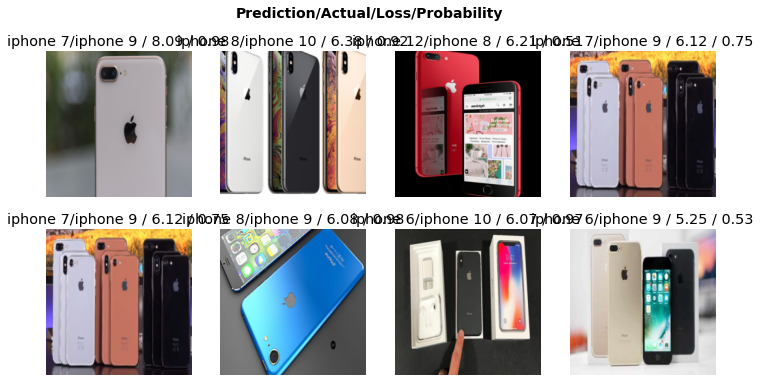

In [ ]:
interpret_mistakes.plot_top_losses(8)

### Use this final model to make some predictions on test images
- Provide 3 tests and see how the learner does!